# <center>Modeling and Simulation of Astrobee<center>

<p align="center">
  <center><img src="Astrobee.png" width="500" height="276"><center>
  <center>Source: <a href="https://ntrs.nasa.gov/search.jsp?R=20180003515">Fl&uumlckiger et al. (2018)</a><center>
</p>

## Dependencies

In [1]:
import sympy as sm
import sympy.physics.mechanics as me
from pydy.system import System
import numpy as np
import matplotlib.pyplot as plt
from pydy.codegen.ode_function_generators import generate_ode_function
from scipy.integrate import odeint
me.init_vprinting()

## Reference Frames

In [2]:
ISS = me.ReferenceFrame('N') # ISS RF
B = me.ReferenceFrame('B') # body RF

q0, q1, q2, q3 = me.dynamicsymbols('q0:4') # attitude coordinates (quaternion angles)

B.orient(ISS, 'Quaternion', (q0, q1, q2, q3)) # body RF

In [3]:
t = me.dynamicsymbols._t

## Significant Points

In [4]:
O = me.Point('O') # fixed point in the ISS
O.set_vel(ISS, 0)

In [5]:
x, y, z = me.dynamicsymbols('x, y, z') # translation coordinates (position of the mass-center of Astrobee relative to 'O')
l = sm.symbols('l') # length of Astrobee (side of cube)

In [6]:
C = O.locatenew('C', x * ISS.x + y * ISS.y + z * ISS.z) # Astrobee CM

## Kinematical Differential Equations

In [7]:
ux = me.dynamicsymbols('u_x')
uy = me.dynamicsymbols('u_y')
uz = me.dynamicsymbols('u_z')
u0 = me.dynamicsymbols('u_0')
u1 = me.dynamicsymbols('u_1')
u2 = me.dynamicsymbols('u_2')
u3 = me.dynamicsymbols('u_3')

In [8]:
z1 = sm.Eq(ux, x.diff())
z2 = sm.Eq(uy, y.diff())
z3 = sm.Eq(uz, z.diff())
z4 = sm.Eq(u0, q0.diff())
z5 = sm.Eq(u1, q1.diff())
z6 = sm.Eq(u2, q2.diff())
z7 = sm.Eq(u3, q3.diff())
u = sm.solve([z1, z2, z3, z4, z5, z6, z7], x.diff(), y.diff(), z.diff(), q0.diff(), q1.diff(), q2.diff(), q3.diff())
u

## Angular Motion

### Angular Velocity

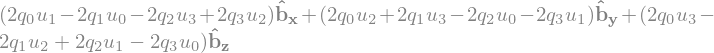

In [9]:
B.set_ang_vel(ISS, B.ang_vel_in(ISS).subs(u))
Omega_B_ISS_B = B.ang_vel_in(ISS)
Omega_B_ISS_B # "angular velocity of body RF w.r.t ISS RF expressed in body RF" 

### Angular Acceleration

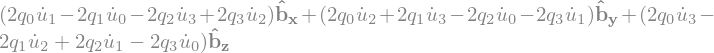

In [10]:
Alpha_B_ISS_B = B.ang_acc_in(ISS).subs(u)
Alpha_B_ISS_B # "angular acceleration of body RF w.r.t ISS RF expressed in body RF" 

## Translational Motion

### Velocity

In [11]:
C.set_vel(ISS, C.pos_from(O).dt(ISS).subs(u))
V_B_ISS_ISS = C.vel(ISS)
V_B_ISS_ISS # "velocity of Astrobee CM w.r.t ISS RF expressed in ISS RF" 

### Acceleration

In [12]:
A_B_ISS_ISS = C.acc(ISS).subs(u)
A_B_ISS_ISS # "acceleration of Astrobee CM w.r.t ISS RF expressed in ISS RF" 

## Mass and Inertia

In [13]:
m = sm.symbols('m') # Astrobee mass

Ix, Iy, Iz = sm.symbols('I_x, I_y, I_z') # principal moments of inertia

I = me.inertia(B, Ix, Iy, Iz) # inertia dyadic
I

## Loads

### Forces

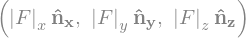

In [14]:
Fx_mag, Fy_mag, Fz_mag = me.dynamicsymbols('Fmag_x, Fmag_y, Fmag_z')

Fx = Fx_mag * ISS.x
Fy = Fy_mag * ISS.y
Fz = Fz_mag * ISS.z

Fx, Fy, Fz

### Torques

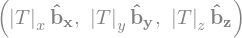

In [15]:
Tx_mag, Ty_mag, Tz_mag = me.dynamicsymbols('Tmag_x, Tmag_y, Tmag_z')

Tx = Tx_mag * B.x
Ty = Ty_mag * B.y
Tz = Tz_mag * B.z

Tx, Ty, Tz

## Kane's Method

In [16]:
kdes = [z1.rhs - z1.lhs, z2.rhs - z2.lhs, z3.rhs - z3.lhs, z4.rhs - z4.lhs, z5.rhs - z5.lhs, z6.rhs - z6.lhs, z7.lhs - z7.rhs]

In [17]:
body = me.RigidBody('body', C, B, m, (I, C))
bodies = [body]

In [18]:
loads = [(C, Fx),
         (C, Fy),
         (C, Fz),
         (B, Tx),
         (B, Ty),
         (B, Tz)
        ]

In [19]:
kane = me.KanesMethod(ISS, (x, y, z, q0, q1, q2, q3), (ux, uy, uz, u0, u1, u2, u3), kd_eqs=kdes)

In [20]:
fr, frstar = kane.kanes_equations(bodies, loads=loads)

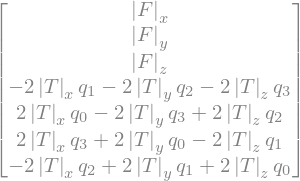

In [21]:
fr

In [22]:
# frstar

## Simulation

In [23]:
sys = System(kane)

In [24]:
sys.constants_symbols

In [25]:
sys.constants = {Ix: 0.1083,
                 Iy: 0.1083,
                 Iz: 0.1083,
                 m: 7
                 }

In [26]:
sys.times = np.linspace(0.0, 50.0, num=1000)

In [27]:
sys.coordinates

In [28]:
sys.speeds

In [29]:
sys.states

In [100]:
theta = 0.5
lambda_1 = 1
lambda_2 = 0
lambda_3 = 0
sys.initial_conditions = {x: 0.0,
                          y: 0.0,
                          z: 0.0,
                          q0: sm.cos(theta/2),
                          q1: lambda_1 * sm.sin(theta/2),
                          q2: lambda_2 * sm.sin(theta/2),
                          q3: lambda_3 * sm.sin(theta/2),
                          ux: 0.0,
                          uy: 0.0,
                          uz: 0.0,
                          u0: 0.0,
                          u1: 0.0,
                          u2: 0.0,
                          u3: 0.0
                         }

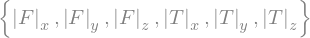

In [101]:
sys.specifieds_symbols

In [102]:
sys.specifieds = {Fx_mag: 0.0,
                  Fy_mag: 0.0,
                  Fz_mag: 0.0,
                  Tx_mag: 0.0,
                  Ty_mag: 0.0,
                  Tz_mag: 0.0
                 }

In [103]:
s = sys.integrate()

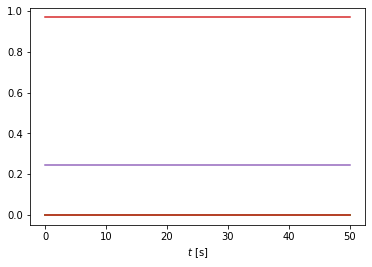

In [104]:
fig, ax = plt.subplots()
ax.plot(sys.times, s)
ax.set_xlabel('{} [s]'.format(sm.latex(t, mode='inline')));
plt.show()

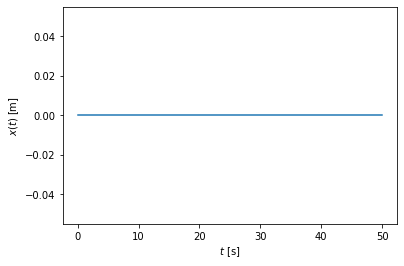

In [105]:
fig, ax = plt.subplots()
ax.plot(sys.times, s[:, 0])
ax.set_xlabel('{} [s]'.format(sm.latex(t, mode='inline'))); ax.set_ylabel('{} [m]'.format(sm.latex(x, mode='inline')));
plt.show()

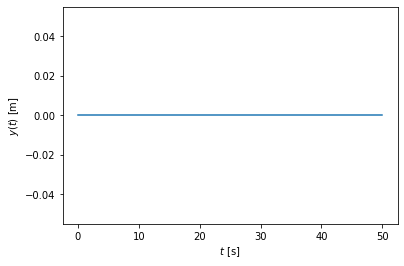

In [106]:
fig, ax = plt.subplots()
ax.plot(sys.times, s[:, 1])
ax.set_xlabel('{} [s]'.format(sm.latex(t, mode='inline'))); ax.set_ylabel('{} [m]'.format(sm.latex(y, mode='inline')));
plt.show()

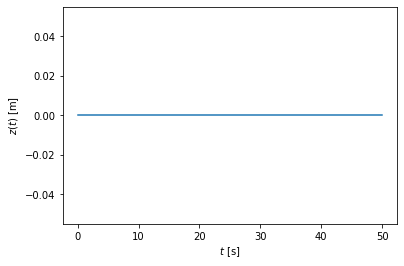

In [107]:
fig, ax = plt.subplots()
ax.plot(sys.times, s[:, 2])
ax.set_xlabel('{} [s]'.format(sm.latex(t, mode='inline'))); ax.set_ylabel('{} [m]'.format(sm.latex(z, mode='inline')));
plt.show()

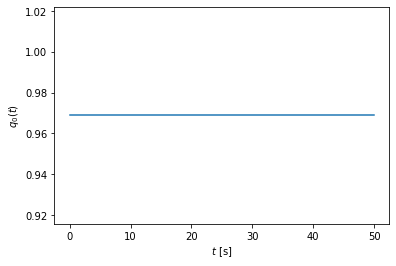

In [108]:
fig, ax = plt.subplots()
ax.plot(sys.times, s[:, 3])
ax.set_xlabel('{} [s]'.format(sm.latex(t, mode='inline'))); ax.set_ylabel('{}'.format(sm.latex(q0, mode='inline')));
plt.show()

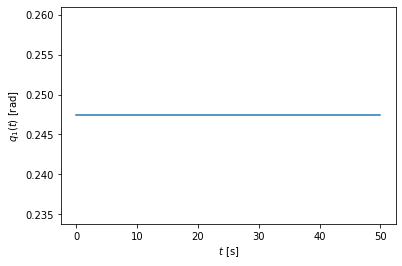

In [109]:
fig, ax = plt.subplots()
ax.plot(sys.times, s[:, 4])
ax.set_xlabel('{} [s]'.format(sm.latex(t, mode='inline'))); ax.set_ylabel('{} [rad]'.format(sm.latex(q1, mode='inline')));
plt.show()

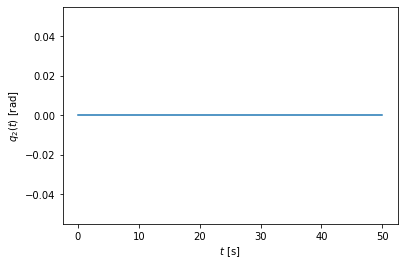

In [110]:
fig, ax = plt.subplots()
ax.plot(sys.times, s[:, 5])
ax.set_xlabel('{} [s]'.format(sm.latex(t, mode='inline'))); ax.set_ylabel('{} [rad]'.format(sm.latex(q2, mode='inline')));
plt.show()

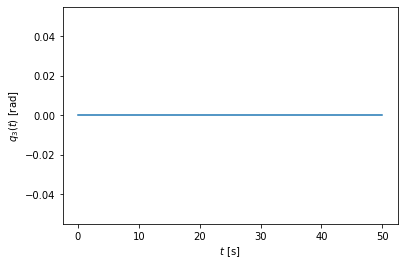

In [111]:
fig, ax = plt.subplots()
ax.plot(sys.times, s[:, 6])
ax.set_xlabel('{} [s]'.format(sm.latex(t, mode='inline'))); ax.set_ylabel('{} [rad]'.format(sm.latex(q3, mode='inline')));
plt.show()

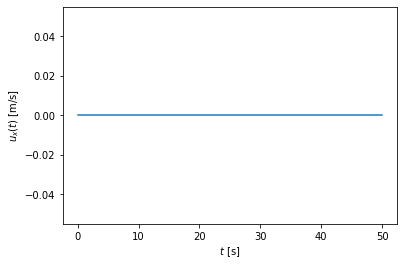

In [112]:
fig, ax = plt.subplots()
ax.plot(sys.times, s[:, 7])
ax.set_xlabel('{} [s]'.format(sm.latex(t, mode='inline'))); ax.set_ylabel('{} [m/s]'.format(sm.latex(ux, mode='inline')));
plt.show()

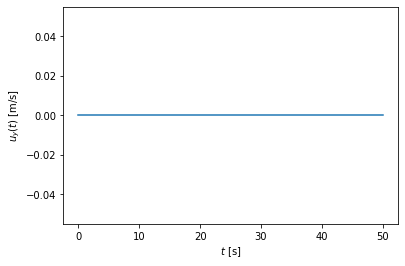

In [113]:
fig, ax = plt.subplots()
ax.plot(sys.times, s[:, 8])
ax.set_xlabel('{} [s]'.format(sm.latex(t, mode='inline'))); ax.set_ylabel('{} [m/s]'.format(sm.latex(uy, mode='inline')));
plt.show()

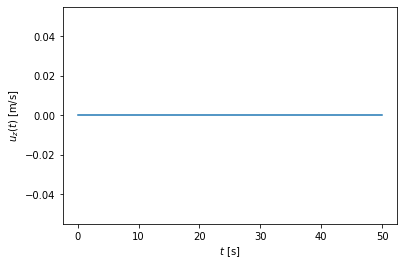

In [114]:
fig, ax = plt.subplots()
ax.plot(sys.times, s[:, 9])
ax.set_xlabel('{} [s]'.format(sm.latex(t, mode='inline'))); ax.set_ylabel('{} [m/s]'.format(sm.latex(uz, mode='inline')));
plt.show()

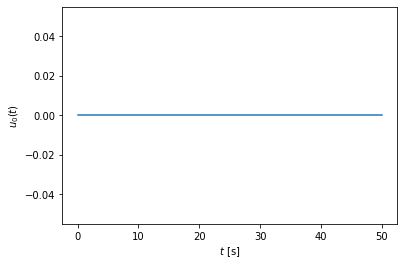

In [115]:
fig, ax = plt.subplots()
ax.plot(sys.times, s[:, 10])
ax.set_xlabel('{} [s]'.format(sm.latex(t, mode='inline'))); ax.set_ylabel('{}'.format(sm.latex(u0, mode='inline')));
plt.show()

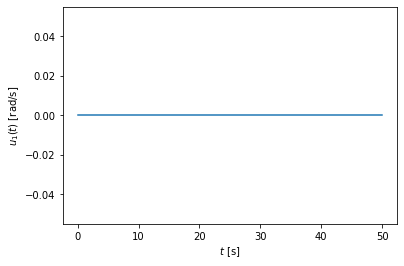

In [116]:
fig, ax = plt.subplots()
ax.plot(sys.times, s[:, 11])
ax.set_xlabel('{} [s]'.format(sm.latex(t, mode='inline'))); ax.set_ylabel('{} [rad/s]'.format(sm.latex(u1, mode='inline')));
plt.show()

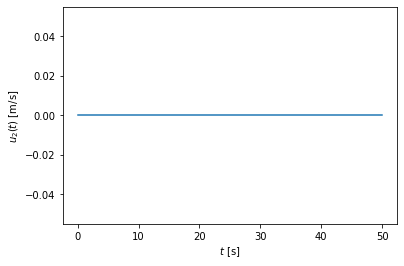

In [117]:
fig, ax = plt.subplots()
ax.plot(sys.times, s[:, 12])
ax.set_xlabel('{} [s]'.format(sm.latex(t, mode='inline'))); ax.set_ylabel('{} [m/s]'.format(sm.latex(u2, mode='inline')));
plt.show()

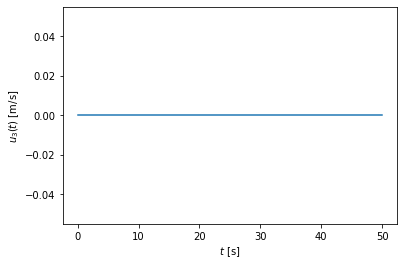

In [118]:
fig, ax = plt.subplots()
ax.plot(sys.times, s[:, 13])
ax.set_xlabel('{} [s]'.format(sm.latex(t, mode='inline'))); ax.set_ylabel('{} [m/s]'.format(sm.latex(u3, mode='inline')));
plt.show()

## 3D Visualization

In [119]:
from pydy.viz.shapes import Cube, Cylinder, Sphere, Plane
from pydy.viz.visualization_frame import VisualizationFrame
from pydy.viz import Scene
from ipywidgets import Image, Video
import pythreejs as pjs

In [120]:
l = 0.32

In [121]:
body_m_shape = Cube(0.32, color='black')
body_l_shape = Cube(0.32, color='green')
body_r_shape = Cube(0.32, color='green')

In [122]:
v1 = VisualizationFrame('Body_m',
                        B,
                        C.locatenew('C_m', (1/6) * l * B.z),
                        body_m_shape)

v2 = VisualizationFrame('Body_l',
                        B,
                        C.locatenew('C_l', (3/8) * l * -B.y),
                        body_l_shape)

v3 = VisualizationFrame('Body_r',
                        B,
                        C.locatenew('C_l', (3/8) * l * B.y),
                        body_l_shape)

In [123]:
scene = Scene(ISS, O, v1, v2, v3, system=sys)
scene.create_static_html(overwrite=True, silent=True)

In [124]:
body_m_mesh = pjs.Mesh(
    pjs.BoxBufferGeometry(l, (1/2) * l, (2/3) * l),
    pjs.MeshStandardMaterial(color='black'),
    name="Body_m"
)

body_l_mesh = pjs.Mesh(
    pjs.BoxBufferGeometry(l, (1/4) * l, l),
    pjs.MeshStandardMaterial(color='green'),
    name="Body_l"
)

body_r_mesh = pjs.Mesh(
    pjs.BoxBufferGeometry(l, (1/4) * l, l),
    pjs.MeshStandardMaterial(color='green'),
    name="Body_r"
)

In [125]:
body_m_matrices = v1.evaluate_transformation_matrix(s, list(sys.constants.values()))
body_l_matrices = v2.evaluate_transformation_matrix(s, list(sys.constants.values()))
body_r_matrices = v3.evaluate_transformation_matrix(s, list(sys.constants.values()))

body_m_track = pjs.VectorKeyframeTrack(
    name='scene/Body_m.matrix',
    times=list(sys.times),
    values=body_m_matrices)

body_l_track = pjs.VectorKeyframeTrack(
    name='scene/Body_l.matrix',
    times=list(sys.times),
    values=body_l_matrices)

body_r_track = pjs.VectorKeyframeTrack(
    name='scene/Body_r.matrix',
    times=list(sys.times),
    values=body_r_matrices)

In [126]:
body_m_mesh.matrixAutoUpdate = False
body_l_mesh.matrixAutoUpdate = False
body_r_mesh.matrixAutoUpdate = False

In [127]:
body_m_mesh.matrix = body_m_matrices[0]
body_l_mesh.matrix = body_l_matrices[0]
body_r_mesh.matrix = body_r_matrices[0]

In [134]:
x_arrow = pjs.ArrowHelper(dir=[1, 0, 0], length=0.75, color='blue')
y_arrow = pjs.ArrowHelper(dir=[0, 1, 0], length=0.75, color='red')
z_arrow = pjs.ArrowHelper(dir=[0, 0, 1], length=0.75,color='green')

In [143]:
view_width = 960
view_height = 720

camera = pjs.PerspectiveCamera(position=[1, 1, 1],
                               aspect=view_width/view_height)
key_light = pjs.DirectionalLight(position=[1, 1, 0])
ambient_light = pjs.AmbientLight()

scene_pjs = pjs.Scene(children=[body_m_mesh, body_l_mesh, body_r_mesh,
                                x_arrow, y_arrow, z_arrow, 
                                camera, key_light, ambient_light])

controller = pjs.OrbitControls(controlling=camera)
renderer = pjs.Renderer(camera=camera, scene=scene_pjs, controls=[controller], width=view_width, height=view_height)

In [144]:
renderer

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, position=(1.0, 1.0, 1.0), projectionMatrix=(1.608…

In [82]:
clip = pjs.AnimationClip(tracks=[body_m_track, body_l_track, body_r_track], duration=sys.times[-1])
action = pjs.AnimationAction(pjs.AnimationMixer(scene_pjs), clip, scene_pjs)
action

AnimationAction(clip=AnimationClip(duration=50.0, tracks=(VectorKeyframeTrack(name='scene/Body_m.matrix', time…